In [2]:
%load_ext autoreload
%autoreload 2

# Imports

In [3]:
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import vis_sampled_histplot
from bioreaction.misc.misc import load_json_as_dict
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import jax.numpy as jnp
import jax

In [4]:
top_write_dir = os.path.join('data', '05_hidden_size', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)
df_hpos = pd.DataFrame(load_json_as_dict(
    'data/2025_01_13__16_31_26/df_hpos_main.json'))
df_hpos['mi_mean'] = np.nan
df_hpos.loc[df_hpos['run_successful'], 'mi_mean'] = df_hpos[df_hpos['run_successful']]['mutual_information_conditionality'].apply(np.array).apply(np.mean)


def load_params(fn_saves):
    saves_loaded = load_json_as_dict(fn_saves)
    params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
    params = arrayise(params)
    return params



In [ ]:
hpos = df_hpos.iloc[0]
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    _, 
    encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)


params = load_params(hpos['filename_saved_model'])

h_all = encoder(params, rng, np.concatenate([x, cond], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)
cond_rev_all = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond, col=config_dataset.objective_col[0]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).reshape(np.prod(x.shape[:-1]), -1).squeeze()

Text(0.5, 1.0, 'Mutual information between hidden z and conditional input')

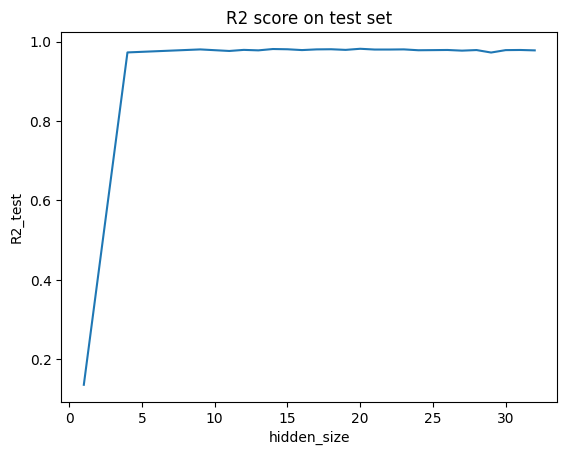

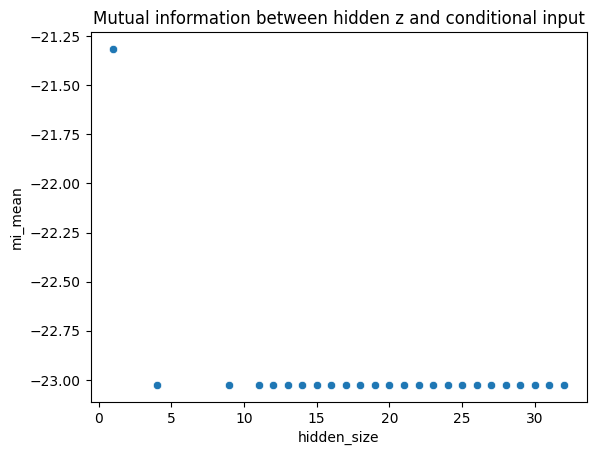

In [40]:
d = df_hpos[df_hpos['run_successful']]

sns.lineplot(d, x='hidden_size', y='R2_test')
plt.title('R2 score on test set')
plt.figure()
sns.scatterplot(d, x='hidden_size', y='mi_mean')
plt.title('Mutual information between hidden z and conditional input')


In [93]:
analytics = load_json_as_dict(os.path.join(os.path.dirname(hpos['filename_saved_model']), 'analytics.json'))
analytics['sensitivity_wrt_species-6'] = np.array(analytics['sensitivity_wrt_species-6'])
analytics['precision_wrt_species-6'] = np.array(analytics['precision_wrt_species-6'])
for k in ['sensitivity_wrt_species-6', 'precision_wrt_species-6']:
    # analytics[k] = np.where(np.isnan(
    #     analytics[k]), 0, analytics[k])
    analytics[f'Log {k.split("_")[0]}'] = np.log10(analytics[k])
analytics['adaptation'] = calculate_adaptation(analytics['sensitivity_wrt_species-6'], analytics['precision_wrt_species-6'])

nbin = hpos['prep_y_categorical_n_bins']
analytics['Log sensitivity'] = analytics['Log sensitivity'].reshape(nbin, analytics['Log sensitivity'].shape[0]//nbin, -1)

In [100]:
idx_output = -1
sampled_cond = np.array(list(y_datanormaliser.metadata['Log sensitivity']['category_map'].values()))

means_s = jax.vmap(lambda x, c: jnp.nanmean(x[..., idx_output]) - c)(analytics['Log sensitivity'], sampled_cond)

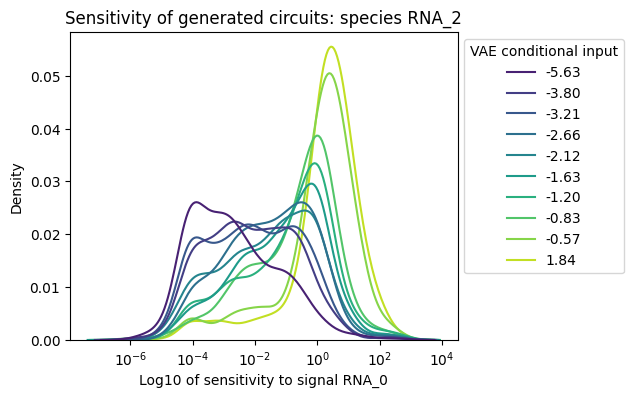

In [106]:

def vis_sampled_histplot(analytic, y_datanormaliser, idx_output: int, output_species,
                         title: str, x_label: str, multiple='fill', show=False, f=sns.histplot, **kwargs):
    if f == sns.histplot:
        for k, v in zip(('element', 'bins', 'log_scale'), ('step', 20, [True, False])):
            kwargs.setdefault(k, v)
    category_array = np.array(sorted(y_datanormaliser.metadata[y_datanormaliser.cols_separate[0]]["category_map"].values())).repeat(
        len(analytic)//len(y_datanormaliser.metadata[y_datanormaliser.cols_separate[0]]["category_map"]))

    fig = plt.figure(figsize=(13, 4))
    fig.subplots_adjust(wspace=0.6)
    for i, output_specie in enumerate(output_species):
        title_curr = title + f': species {output_specie}'
        df_s = pd.DataFrame(columns=[x_label, 'VAE conditional input'],
                            data=np.concatenate([analytic[:, idx_output][:, None], category_array[:, None]], axis=-1))
        df_s['VAE conditional input'] = df_s['VAE conditional input'].astype(
            float).apply(lambda x: f'{x:.2f}')
        ax = plt.subplot(1, 2, i+1)
        f(df_s, x=x_label,
          multiple=multiple, hue='VAE conditional input', palette='viridis',
          **kwargs)

        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.title(title_curr)

    if show:
        plt.show()
        
        
idx_output = -1
vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], y_datanormaliser, idx_output, config_dataset.output_species,
                     title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer', show=True,
                     f=sns.kdeplot, log_scale=[True, False], fill=False)

<Axes: >

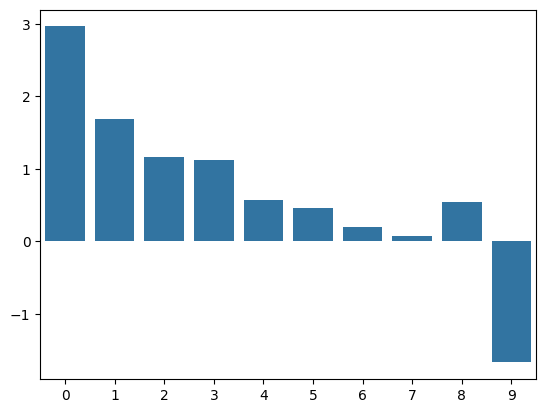

In [101]:
sns.barplot(means_s)

In [55]:
np.array(analytics['RMSE']).shape

(10000, 9)

In [19]:
for fn_save in df_hpos['filename_saved_model']:
    if 'TO_BE_RECORDED' in fn_save:
        continue
    pass
    # init_from_hpos(fn_save, params, top_write_dir, df_hpos, fn_save)